In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # FFFFF

# Data loading
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# Auxiliary functions
from torch.utils.tensorboard import SummaryWriter  # Used for Tensorboard logging
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil
import datetime

import json

from dataset_semseg import SupermarketSemSeg

import matplotlib.patches as mpatches
import matplotlib.cm as cm

from sklearn.metrics import f1_score   

# Segmentación de imagen mediante arquitectura U-Net

In [2]:
PATH_ROOT = os.path.join('.')
# Ruta para datos:
PATH_DATA = os.path.join(PATH_ROOT, 'data')
# Ruta para modelos:
PATH_MODELS = os.path.join(PATH_ROOT, 'reports', 'models')
# Ruta para resultados:
PATH_RESULTS = os.path.join(PATH_ROOT, 'reports', 'results')
# Ruta para ejecuciones:
PATH_RUNS = os.path.join(PATH_ROOT, 'reports', 'runs')

In [3]:
# Para cada sesión creamos un directorio nuevo, a partir de la fecha y hora de su ejecución:
date = datetime.datetime.now()
test_name = str(date.year) + '_' + str(date.month) + '_' +  str(date.day) + '__' + str(date.hour) + '_' + str(date.minute)
print('Nombre del directorio de pruebas: {}'.format(test_name))
models_folder = os.path.join(PATH_MODELS, test_name)
try:
    os.makedirs(models_folder)
except:
    print(f'Folder {models_folder} already existed.')
results_folder = os.path.join(PATH_RESULTS, test_name)
try:
    os.makedirs(results_folder)
except:
    print(f'Folder {results_folder} already existed.')
runs_folder = os.path.join(PATH_RUNS, test_name)
try:
    os.makedirs(runs_folder)
except:
    print(f'Folder {runs_folder} already existed.')


Nombre del directorio de pruebas: 2025_11_30__11_35


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   

cuda


## Definición del modelo

Como vamos a repetir la estructura de Convolución, Convolución, pooling, hacemos una clase para ello

In [5]:
class DoubleConv(nn.Module):
    """
    Conv3x3 -> ReLU -> Conv3x3 -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [6]:
class Down(nn.Module):
    """
    MaxPool2x2 -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


In [7]:
class Up(nn.Module):
    """
    UpConv2x2 -> concat con skip -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)  # in_channels = (up_out + skip)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, base_ch=64, depth=4):
        super().__init__()
        self.num_classes = num_classes
        self.depth = depth
        
        self.inc = DoubleConv(in_channels, base_ch)
        
        # Encoder
        self.downs = nn.ModuleList()
        for i in range(depth):
            ch_in = base_ch * (2**i)      # Canales de entrada: 64, 128, 256, 512
            ch_out = base_ch * (2**(i+1)) # Canales de salida: 128, 256, 512, 1024
            self.downs.append(Down(ch_in, ch_out))
        
        # Decoder
        self.ups = nn.ModuleList()
        for i in range(depth):
            ch_in = base_ch * (2**(depth-i))    # Canales de entrada: 1024, 512, 256, 128
            ch_out = base_ch * (2**(depth-i-1)) # Canales de salida: 512, 256, 128, 64
            self.ups.append(Up(ch_in, ch_out))
        
        self.outc = nn.Conv2d(base_ch, num_classes, kernel_size=1)
    
    def forward(self, x):
        # guardamos skip connections
        skips = [self.inc(x)]
        for down in self.downs:
            skips.append(down(skips[-1]))
        
        # usamos skip connections en reversa
        x = skips[-1]
        for i, up in enumerate(self.ups):
            x = up(x, skips[-(i+2)])
        
        return self.outc(x)

## Carga de Datos

Cargamos los dos conjuntos de datos (elegir)

10 clases

In [9]:
clase = "train"
root_images_train = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_train = f"./dataset_res_144_192_10classes/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_test = f"./dataset_res_144_192_10classes/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

num_classes = 11

Todas las clases

In [10]:
# clase = "train"
# root_images_train = f"./dataset_res_144_192/{clase}/images/"
# root_masks_train = f"./dataset_res_144_192/{clase}/masks/"

# clase = "test"
# root_images_test = f"./dataset_res_144_192/{clase}/images/"
# root_masks_test = f"./dataset_res_144_192/{clase}/masks/"

# dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
# dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

# num_classes = 61

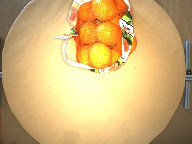

In [11]:
x = dataset_train.__getitem__(400)
mask = x["mask"]
dataset_train._read_image(p = x["image_path"])

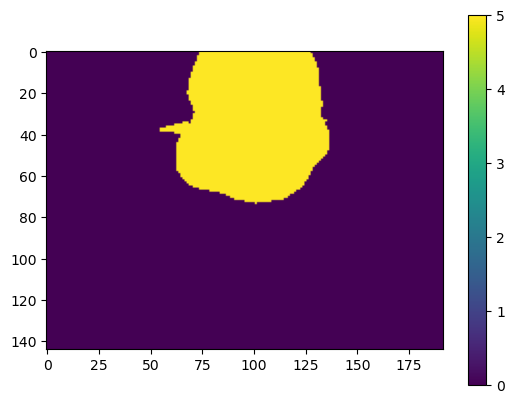

In [12]:
plt.imshow(mask.numpy())
plt.colorbar()
plt.show()

In [13]:
total_size = len(dataset_train)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    dataset_train, 
    [train_size, val_size], 
    generator=generator
)

batch_size = 4  # Tamaño de lotes
num_workers = 0  # Controla cuántos procesos cargan datos en paralelo (lo dejaremos a 0 para ahorrar recursos)

Calculamos la media y las desviaciones para cada canal para poder aplicar las transformaciones

In [14]:
# loader temporal para calcular mean y std
train_loader_tmp = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)


mean = 0.0
std = 0.0
num_ejemplos = 0

for data in train_loader_tmp:
    imgs = data["image"]
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)  # pasamos a (B, C, H*W)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    num_ejemplos += batch_samples
mean /= num_ejemplos
std /= num_ejemplos

print(mean)
print(std)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

tensor([0.5035, 0.4309, 0.2920])
tensor([0.1516, 0.1417, 0.1150])


In [15]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
dataset_test.transform = test_transform

In [16]:
train_loader = DataLoader(
    dataset=train_dataset,      
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_dataset,        
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)


In [17]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, writer=None, scheduler=None):

    train_losses = []
    val_losses = []

    num_classes = model.num_classes

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        train_preds = []
        train_masks = []

        # --------- TRAIN ---------
        for batch in train_loader:
            imgs = batch["image"].to(device)          # (B, 3, H, W)
            masks = batch["mask"].long().to(device)   # (B, H, W)

            optimizer.zero_grad()

            outputs = model(imgs)                     # (B, C, H, W)
            probs = torch.softmax(outputs, dim=1)     # Probabilidades por pixel
            loss = criterion(outputs, masks)

            preds = probs.argmax(1)                   # Predicción a partir de probas

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()

            train_preds.append(preds)
            train_masks.append(masks)

        avg_train_loss = running_loss / len(train_loader)
        train_pixel_acc = running_correct / running_total
        train_losses.append(avg_train_loss)
        
        train_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in train_masks]),
            torch.cat([t.flatten().cpu() for t in train_preds]),
            average='macro',
            zero_division=0
        )

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_pixel_acc:.4f} - Train F1: {train_f1:.4f}")
        if writer is not None:
            writer.add_scalar('train/loss', avg_train_loss, epoch)
            writer.add_scalar('train/pixel_acc', train_pixel_acc, epoch)
            writer.add_scalar('train/f1_score', train_f1, epoch)

        # --------- VALIDACIÓN ---------
        model.eval()
        running_val_loss = 0.0
        running_val_correct = 0
        running_val_total = 0

        val_preds = []
        val_masks = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):

                imgs = batch["image"].to(device)
                masks = batch["mask"].long().to(device)

                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)   # [B, C, H, W]
                loss = criterion(outputs, masks)
                
                preds = probs.argmax(1)                 # [B, H, W]

                running_val_loss += loss.item()
                running_val_correct += (preds == masks).sum().item()
                running_val_total += masks.numel()

                val_preds.append(preds)
                val_masks.append(masks)

                # ---- LOG DE IMÁGENES Y MAPAS DE PROB SOLO UNA VEZ (última época) ----
                if writer is not None and batch_idx == 0 and epoch == epochs - 1:
                    imgs_cpu  = imgs[0:1].cpu()      # primer ejemplo (B=1)
                    probs_cpu = probs[0:1].cpu()     # (1, C, H, W)

                    # Desnormalizamos para visualizar los colores correctamente
                    mean_vec = mean.view(1, -1, 1, 1)
                    std_vec  = std.view(1, -1, 1, 1)
                    img_denorm = (imgs_cpu * std_vec + mean_vec)[0]  # (C,H,W)
                    img_np = img_denorm.permute(1, 2, 0).numpy()
                    img_np = np.clip(img_np, 0, 1)

                    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
                    axes = axes.flatten()

                    for cls in range(num_classes):
                        ax = axes[cls]

                        prob_map = probs_cpu[0, cls].numpy()  # (H, W)

                        ax.imshow(img_np, alpha=0.45)
                        ax.imshow(prob_map, cmap='viridis', alpha=0.75)

                        ax.set_title(f"Clase {cls}")
                        ax.axis("off")

                    for i in range(num_classes, 12):
                        axes[i].axis("off")

                    plt.tight_layout()
                    writer.add_figure("val/prob_maps", fig, epoch)
                    plt.close(fig)

        avg_val_loss = running_val_loss / len(val_loader)
        val_pixel_acc = running_val_correct / running_val_total
        val_losses.append(avg_val_loss)

        val_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in val_masks]),
            torch.cat([t.flatten().cpu() for t in val_preds]),
            average='macro',
            zero_division=0
        )

        print(f"           Val Loss: {avg_val_loss:.4f} - Val Pixel Acc: {val_pixel_acc:.4f} - Val F1: {val_f1:.4f}")
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            
        # TensorBoard: scalars de VAL
        if writer is not None:
            writer.add_scalar('val/loss', avg_val_loss, epoch)
            writer.add_scalar('val/pixel_acc', val_pixel_acc, epoch)
            writer.add_scalar('val/f1_score', val_f1, epoch)

        # Tensorboard: Histogramas de pesos y gradientes
        if writer is not None:
            for name, p in model.named_parameters():
                if p.requires_grad:
                    writer.add_histogram(f'params/{name}', p.detach().cpu(), epoch)
                    if p.grad is not None:
                        writer.add_histogram(f'grads/{name}', p.grad.detach().cpu(), epoch)

    return train_losses, val_losses


In [18]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device)

            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = probs.argmax(1)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()
            
    avg_loss = running_loss / len(test_loader)
    pixel_acc = running_correct / running_total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Pixel Accuracy: {pixel_acc:.4f}")

    return avg_loss, pixel_acc


In [19]:
#weights = torch.ones(num_classes, device=device, dtype=torch.float)
#weights[0] = 0.2 # valor arbitrario

Utilizaremos el optimizador Adam por su robustez porque es el estandar en el sector para este tipo de problemas. Podriamos probar y otros compararlos, pero como este funciona correctamente optaremos por mejorar el modelo posteriormente en otros aspectos que tengan mayor impacto.

In [20]:
model = UNet(
    in_channels=3,
    num_classes=num_classes,
    base_ch=64
).to(device)

criterion = nn.CrossEntropyLoss()
lr = 5e-4
weight_decay = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay) # weight_decay equivale a añadir regularización L2 donde weight_decay es lambda
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
writer = SummaryWriter(log_dir=runs_folder)

train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    scheduler=scheduler,
    writer=writer
)

Epoch 1/20 - Train Loss: 0.5363 - Train Acc: 0.8882 - Train F1: 0.1408
           Val Loss: 0.2395 - Val Pixel Acc: 0.9371 - Val F1: 0.2257
Epoch 2/20 - Train Loss: 0.1949 - Train Acc: 0.9474 - Train F1: 0.2638
           Val Loss: 0.1656 - Val Pixel Acc: 0.9520 - Val F1: 0.2781
Epoch 3/20 - Train Loss: 0.1517 - Train Acc: 0.9544 - Train F1: 0.2815
           Val Loss: 0.1422 - Val Pixel Acc: 0.9559 - Val F1: 0.2974
Epoch 4/20 - Train Loss: 0.1361 - Train Acc: 0.9575 - Train F1: 0.3204
           Val Loss: 0.1547 - Val Pixel Acc: 0.9602 - Val F1: 0.3385
Epoch 5/20 - Train Loss: 0.1308 - Train Acc: 0.9590 - Train F1: 0.3463
           Val Loss: 0.1352 - Val Pixel Acc: 0.9584 - Val F1: 0.3453
Epoch 6/20 - Train Loss: 0.1302 - Train Acc: 0.9591 - Train F1: 0.3645
           Val Loss: 0.1257 - Val Pixel Acc: 0.9633 - Val F1: 0.3726
Epoch 7/20 - Train Loss: 0.1210 - Train Acc: 0.9607 - Train F1: 0.3837
           Val Loss: 0.1218 - Val Pixel Acc: 0.9610 - Val F1: 0.3754
Epoch 8/20 - Train L

Guardamos el modelo

In [21]:
torch.save(model.state_dict(), 'model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')
torch.save(scheduler.state_dict(), 'scheduler.pth')

Cargamos el modelo

In [22]:
model = UNet(
    in_channels=3,
    num_classes=num_classes,
    base_ch=64
).to(device)

model.load_state_dict(torch.load('model.pth', map_location=device))

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer.load_state_dict(torch.load('optimizer.pth', map_location=device))

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
scheduler.load_state_dict(torch.load('scheduler.pth'))

# Elegir modo según lo que vayamos a hacer:
model.eval()  # Para evaluación
# model.train()  # Para continuar entrenamiento

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (downs): ModuleList(
    (0): Down(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
    (1): Down(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2)

In [23]:
test(model, test_loader, criterion, device)

Test Loss: 1.2227
Test Pixel Accuracy: 0.6821


(1.2227429574811053, 0.6820977841031438)

In [24]:
def leer_mapeado(ruta):
    with open(ruta, 'r') as f:
        data = json.load(f)
    clases = {}
    for i in range(len(data)):
        clases[data[i]['index']] = data[i]['name']
    return clases
if num_classes == 11:
    mapeado_clases = leer_mapeado('dataset_res_144_192_10classes/label_mapping_10classes.json')
else:
    mapeado_clases = leer_mapeado('dataset_res_144_192/label_mapping.json')

/tmp/ipykernel_94079/168159538.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', num_classes)


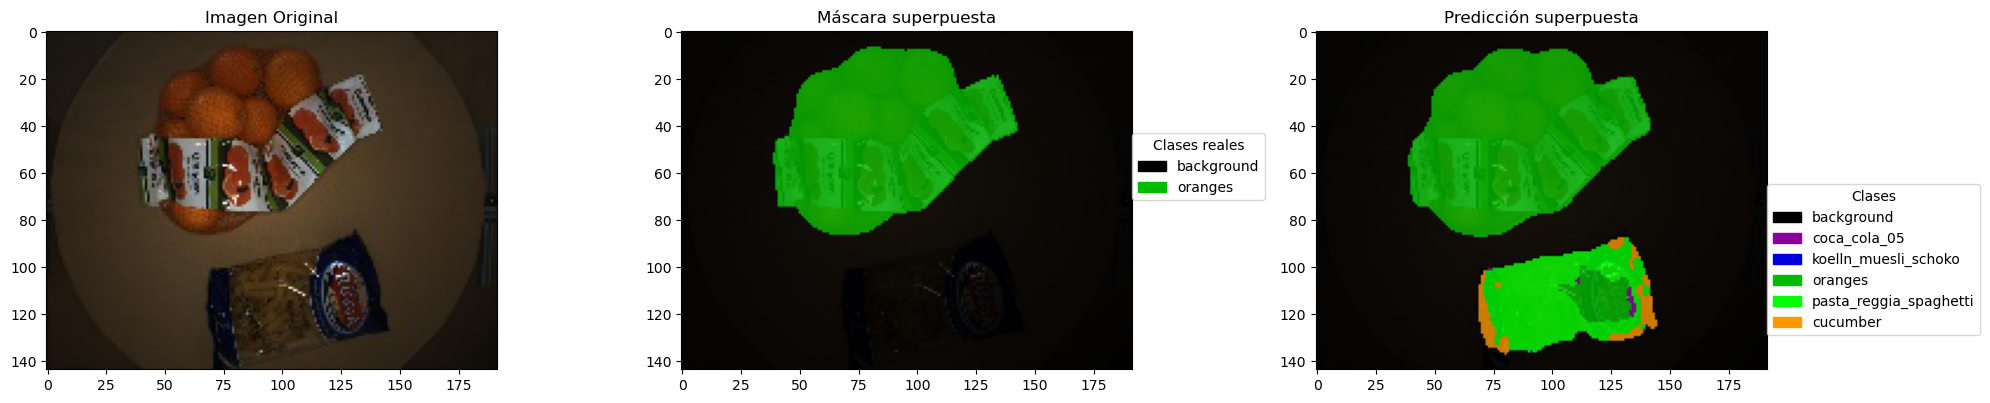

In [25]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm

def ver_prediccion(indice, test = True,  alpha = 0.8, num_classes=None):
    # Asegurar num_classes correcto
    if num_classes is None:
        num_classes = globals().get('num_classes', 11)
    ejemplo = dataset_test[indice] if test else dataset_train[indice]
    x = ejemplo["image"]
    # Dispositivo del modelo
    model_device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        pred = model(x.to(model_device).unsqueeze(0)).argmax(1).squeeze().cpu().numpy()
    mask = ejemplo["mask"].numpy()
    # Manejo de etiquetas fuera de rango (p.ej. 255 como ignore)
    mask = np.where(mask >= num_classes, 0, mask)
    # Colormap discreto con N=num_classes
    cmap = cm.get_cmap('nipy_spectral', num_classes)
    # Denormalizar imagen para visualizar correctamente
    mean_vec = mean.view(1, -1, 1, 1)
    std_vec  = std.view(1, -1, 1, 1)
    img_denorm = (x.unsqueeze(0) * std_vec + mean_vec).squeeze(0)
    img = img_denorm.cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes[0].imshow(img)
    axes[0].set_title('Imagen Original')
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    axes[1].set_title('Máscara superpuesta')
    axes[2].imshow(img)
    axes[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    axes[2].set_title('Predicción superpuesta')

    # Leyendas
    clases_mask = np.unique(mask)
    patches_mask = [mpatches.Patch(color=cmap(int(i)), label=mapeado_clases.get(int(i), str(int(i)))) for i in clases_mask]
    axes[1].legend(handles=patches_mask, loc=[1,0.5], title='Clases reales')
    clases_presentes = np.unique(pred)
    patches = [mpatches.Patch(color=cmap(int(i)), label=mapeado_clases.get(int(i), str(int(i)))) for i in clases_presentes]
    plt.legend(handles=patches, loc=[1,0.1], title='Clases')
    plt.tight_layout()
    plt.show()

ver_prediccion(500, test=True, num_classes=num_classes)

In [26]:
def test_comp(model, test_loader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    
    # Inicializamos la matriz de confusión (Predicción vs Verdad)
    confusion_matrix = torch.zeros(num_classes, num_classes, device=device)

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device) 

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = outputs.argmax(1) # [Batch, Height, Width]

            # --- Actualización de Métricas ---
            # Aplanamos los tensores para comparar píxel a píxel
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # Calculamos índices únicos para la matriz de confusión 
            idx = masks_flat * num_classes + preds_flat
            
            # Contamos ocurrencias 
            count = torch.bincount(idx, minlength=num_classes**2)
            
            # Reformateamos a matriz cuadrada y acumulamos
            confusion_matrix += count.reshape(num_classes, num_classes)

    # --- Cálculos Finales ---
    
    # 1. Global Pixel Accuracy
    # Suma de la diagonal (aciertos) / Suma total
    total_pixels = confusion_matrix.sum()
    correct_pixels = confusion_matrix.diag().sum()
    pixel_acc = correct_pixels / total_pixels

    # 2. Accuracy por Clase (Recall)
    # Diagonal / Suma de cada fila (Total de píxeles reales de esa clase)
    # Agregamos 1e-6 para evitar división por cero si una clase no aparece
    class_acc = confusion_matrix.diag() / (confusion_matrix.sum(1) + 1e-6)

    # 3. Intersection over Union (IoU) por Clase
    # IoU = Intersección / (Area Real + Area Predicha - Intersección)
    intersection = confusion_matrix.diag()
    union = confusion_matrix.sum(1) + confusion_matrix.sum(0) - intersection
    iou_per_class = intersection / (union + 1e-6)
    mean_iou = iou_per_class.mean()

    # 4. Weighted IoU (NUEVO)
    # Obtenemos la cantidad real de píxeles por clase (Suma de las filas de la matriz)
    ground_truth_counts = confusion_matrix.sum(1)
    
    # Calculamos el peso de cada clase
    class_weights = ground_truth_counts / (ground_truth_counts.sum() + 1e-6)
    
    weighted_iou = (iou_per_class * class_weights).sum()

    # --- Reporte ---
    avg_loss = running_loss / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Global Pixel Accuracy: {pixel_acc:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Weighted IoU: {weighted_iou:.4f}")
    print("-" * 30)
    for i, (acc, iou) in enumerate(zip(class_acc, iou_per_class)):
        print(f"Clase {i}: Acc: {acc:.4f} | IoU: {iou:.4f}")

    # Retornamos un diccionario con todo para que sea fácil de usar
    metrics = {
        "loss": avg_loss,
        "pixel_acc": pixel_acc.item(),
        "mean_iou": mean_iou.item(),
        "weighted_iou": weighted_iou.item(),
        "class_acc": class_acc.cpu().numpy(),
        "class_iou": iou_per_class.cpu().numpy()
    }
    
    return metrics

In [27]:
test_comp(model, test_loader, criterion, device,num_classes)

Test Loss: 1.2227
Global Pixel Accuracy: 0.6821
Mean IoU: 0.1563
Weighted IoU: 0.6462
------------------------------
Clase 0: Acc: 0.6901 | IoU: 0.6850
Clase 1: Acc: 0.0877 | IoU: 0.0402
Clase 2: Acc: 0.5842 | IoU: 0.1410
Clase 3: Acc: 0.0081 | IoU: 0.0075
Clase 4: Acc: 0.0356 | IoU: 0.0090
Clase 5: Acc: 0.9955 | IoU: 0.0731
Clase 6: Acc: 0.5625 | IoU: 0.0623
Clase 7: Acc: 0.0843 | IoU: 0.0572
Clase 8: Acc: 0.7266 | IoU: 0.0769
Clase 9: Acc: 0.0855 | IoU: 0.0653
Clase 10: Acc: 0.9224 | IoU: 0.5013


{'loss': 1.2227429545285533,
 'pixel_acc': 0.6820977330207825,
 'mean_iou': 0.1562567800283432,
 'weighted_iou': 0.6462342739105225,
 'class_acc': array([0.69009763, 0.087659  , 0.5841527 , 0.00813898, 0.03558767,
        0.9954616 , 0.5625345 , 0.08425036, 0.72663194, 0.0855451 ,
        0.922393  ], dtype=float32),
 'class_iou': array([0.6850188 , 0.04020388, 0.14101419, 0.00747848, 0.00897901,
        0.07307468, 0.06230434, 0.05716656, 0.07690597, 0.06534267,
        0.501336  ], dtype=float32)}